# Auto-Encoders and Undoing Convolutions

In this notebook, we will tackle the topic of auto-encoders,
a simple trick to use neural networks for unsupervised learning.
Whereas auto-encoders with fully connected layers are pretty simple,
new types of layers are necessary to build convolutional auto-encoders.
The most important of these new layers is the transposed convolution,
which is often confusingly referred to as a deconvolution.

In [1]:
import os.path

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision import models
import torchvision


from PIL import Image
from IPython.core.display import display
from torchvision.transforms.functional import to_pil_image
from torch.nn.functional import max_unpool2d, conv_transpose2d

torch.manual_seed(1806)
torch.cuda.manual_seed(1806)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


print('Python version: 3.9.12')
print('Pytorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)

cpu
Python version: 3.9.12
Pytorch version: 1.13.0
torchvision version: 0.14.0


/var/folders/yn/55hr75q51119y7clshplydwm0000gn/T/ipykernel_42097/1022249172.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
class AutoMNIST(datasets.MNIST):
    """ Wrapper around MNIST for training auto-encoders. """
    
    def __getitem__(self, index):
        x = self.data[index].numpy()
        img = Image.fromarray(x, mode='L')
        target = Image.fromarray(x, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    @property
    def raw_folder(self):
        return os.path.join(self.root, 'MNIST', 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, 'MNIST', 'processed')


def get_auto_mnist_loader(train: bool = True, flat: bool = False, 
                          raw_targets: bool = False, **kwargs) -> DataLoader:
    """
    Construct a data loader for training auto-encoders on MNIST.
    
    Parameters
    ----------
    train : bool, optional
        If `True`, use the MNIST training data, 
        otherwise use the test data.
    flat : bool, optional
        If `True`, the images is flattened in pre-processing.
    raw_targets : bool, optional
        If `True`, the target values are not normalised,
        otherwise (the default), they are normalised
        in the same way as the inputs are.
    kwargs
        Additional keyword arguments for data loader.
        E.g. batch_size, shuffle, num_workers, ...

    Returns
    -------
    loader : DataLoader
        A data loader that iterates over the MNIST data,
        where the inputs are properly normalised images
        and the targets are either the raw images with pixels in [0, 1]
        or equivalent to the inputs, depending on `raw_targets`.
    """
    
    

    #for train and test (EXAMPLE):
        
    
    to_tensor = transforms.ToTensor()
    normalise = transforms.Compose([
        to_tensor, transforms.Normalize((.1307, ), (.3081, ))
    ])
    
    if flat:
        to_tensor = transforms.Compose([to_tensor, nn.Flatten()])
        normalise.transforms.append(nn.Flatten())
    
    _transforms = {
        'transform': normalise,
        'target_transform': to_tensor if raw_targets else normalise
    }
    data = AutoMNIST(root='./dataset', download=True, train=train, **_transforms)
    loader = DataLoader(data, **kwargs)
    return loader

In [3]:
def _forward(network: nn.Module, data: DataLoader, metric: callable):
    device = next(network.parameters()).device
    
    for x, y in data:
        x, y = x.to(device), y.to(device)
        logits = network(x)
        res = metric(logits, y)
        yield res


@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    network.eval()
    
    results = _forward(network, data, metric)
    return [res.item() for res in results]
    

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module, 
           opt: optim.Optimizer) -> list:
    network.train()
    
    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        
        opt.zero_grad()
        err.backward()
        opt.step()
    
    return errs


def train_auto_encoder(auto_encoder: nn.Module, loader: DataLoader, 
                       objective: nn.Module, optimiser: optim.Optimizer, 
                       num_epochs: int = 10, vis_every: int = 2):
    """
    Train an auto-encoder for a number of epochs.
    
    Parameters
    ----------
    auto_encoder : nn.Module
        The auto-encoder to train
    loader : DataLoader
        A data loader for iterating over batches of the data.
    objective : nn.Module
        The loss function to optimise during training.
    optimiser : optim.Optimizer
        The optimiser to use for training.
    num_epochs : int, optional
        Number of times to iterate the dataset.
    vis_every : int, optional
        Frequency, during training, of 
        intermediate visualisation of reconstructions.
    """
    # take random batch for visualising reconstructions
    ref_inputs, _ = next(iter(loader))
    
    # evaluate random performance
    errs = evaluate(auto_encoder, loader, objective)
    print(f"Epoch {0: 2d} - avg loss: {sum(errs) / len(errs):.6f}")
    display_result(auto_encoder, ref_inputs)
    
    # train for some epochs
    for epoch in range(1, num_epochs + 1):
        errs = update(auto_encoder, loader, objective, optimiser)
        print(f"Epoch {epoch: 2d} - avg loss: {sum(errs) / len(errs):.6f}")

        if epoch % vis_every == 0:
            display_result(auto_encoder, ref_inputs)

In [4]:
def data_to_image(*data: torch.Tensor, 
                  means: tuple = (0, ), stds: tuple = (1., )) -> Image:
    """
    Convert multiple tensors to one big image.
    
    Parameters
    ----------
    data0, data1, ... dataN : torch.Tensor
        One or more tensors to be merged into a single image.
    means : tuple or torch.Tensor, optional
        Original mean of the image before normalisation.
    stds : tuple or torch.Tensor, optional
        Original standard deviation of the image before normalisation.

    Returns
    -------
    image : Image
        PIL image with all of the tensors next to each other.
    """
    # concatenate all data
    big_pic = torch.cat([x for x in data], dim=-1)
    
    means = torch.tensor(means)
    stds = torch.tensor(stds)
    to_image = transforms.Compose([
        # inverts normalisation of image
        transforms.Normalize(-means / stds, 1. / stds),
        transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),
        transforms.ToPILImage()
    ])
    
    return to_image(big_pic)


def display_result(auto_encoder: nn.Module, xs: torch.Tensor, count: int = 10):
    """
    Visualise a number of reconstructions from an auto-encoder.
    
    Parameters
    ----------
    auto_encoder : nn.Module
        The auto-encoder to visualise reconstructions for.
    xs : torch.Tensor
        Batch of images to be reconstructed.
        The batch is assumed to have the correct shape
        for feeding it to the network.
    count : int, optional
        Number of samples in the batch to visualise.

    """
    xs = xs[:count]
    model_dev = next(auto_encoder.parameters()).device
    # get reconstructions
    preds = auto_encoder.reconstruct(xs.to(model_dev)).cpu()
    if preds.min() < 0:
        preds = preds * .3081 + .1307    # unnormalise
    
    # convert to images
    xs = xs.view(-1, 1, 28, 28)  # unflatten
    x_im = data_to_image(*xs, means=(.1307, ), stds=(.3081, ))
    preds = preds.view(-1, 1, 28, 28)
    res_im = data_to_image(*preds)
    
    # paste together
    im = Image.new('L', (len(xs) * 28, 56))
    im.paste(x_im, (0, 0))
    im.paste(res_im, (0, 28))
    display(im, metadata={'width': '20%'})

In [5]:
def download_image_data(url: str, md5: str = None, size: int = 224):
    """
    Download and pre-process some image for AlexNet.
    
    Parameters
    ----------
    url : str
        URL to the image.
    md5 : str, optional
        MD5 checksum of the image.
    size : int, optional
        Expected size for the image after cropping.

    Returns
    -------
    x : (1, 3, size, size) torch.Tensor
        Ready-to-predict image.
    """
    from torchvision.datasets.utils import download_url
    path = os.path.expanduser('~/.pytorch')
    download_url(url, path, md5=md5)
    file_name = url.rsplit('/', maxsplit=1)[-1]
    im = Image.open(os.path.join(path, file_name))
    # constants taken from torchvision.models docs
    normalise = transforms.Compose([
        transforms.RandomCrop(size=size),
        transforms.ToTensor(),
        transforms.Normalize((.485, .456, .406), (.229, .224, .225))
    ])
    return normalise(im).unsqueeze(0)

## Auto-Encoders

An easy way to use supervised models in an unsupervised setting 
is to invent a prediction task that only requires the inputs.
The most straightforward approach to this paradigm is to learn the identity function.
It is trivial to find a network that solves this task perfectly (linear regression).
In order to get more interesting models,
it is therefore important to make it slightly harder for the network to learn the identity.

The auto-encoder is a neural network architecture for learning these identity functions.
In general, auto-encoders consist of two parts:
the first part is the encoder, which maps the inputs to some *code*
and the second part is the decoder, which maps this code back to the inputs.

This setup is especially interesting when the code is much smaller than the input.
In this case, the code forms a bottleneck for the information flow,
and the network must learn to compress the information in the inputs to get good reconstructions.
This effectively allows to learn a lossy compression scheme where
the encoder can be used to compress the inputs and the decoder is used for decompression.

### Task 1: Simple Auto-Encoder 

Auto-encoders are pretty straightforward to construct when using fully connected layers.
Since the code size is directly controlled by the hyper-parameters,
it is also very well suited for learning compression.

 > Implement a fully-connected auto-encoder module with single-layer encoders and decoders.
 > Code clearly distinguishes between encoder and decoder, so that the auto-encoder can easily be used to compress inputs and decompress codes.
 > `forward` should return logits!

In [14]:
class AutoEncoder(nn.Module):
    """ Fully connected auto-encoder. """
    
    def __init__(self, in_features: int, code_features: int, 
                 activation: nn.Module = nn.Sigmoid()):
        """
        Parameters
        ----------
        in_features : int
            Dimensionality of the inputs.
        code_features : int
            Dimensionality of the code.
        activation : nn.Module
            Activation function to use for the codes.
        """
        super().__init__()
        
        self.encoder = nn.Linear(in_features,code_features)
        self.decoder = nn.Linear(code_features,in_features)
        self.activation = activation
        
    def forward(self, x):
        x = self.activation(self.encoder(x))
        x = self.decoder(x)
        return x
    
    @torch.no_grad()
    def reconstruct(self, x: torch.Tensor) -> torch.Tensor:
        """
        Properly reconstruct some inputs.
        
        Parameters
        ----------
        x : torch.Tensor
            Inputs to be reconstructed.

        Returns
        -------
        y : torch.Tensor
            Result of reconstruction, with values
            in the same range as the targets.
        """
        logits = self.forward(x)
        return torch.clamp(logits, x.min(), x.max())

In [15]:
# sanity check
ae = AutoEncoder(784, 128)
ae(torch.randn(1, 784))
sum(par.numel() for par in ae.parameters())

201616

### Task 2: Auto-Encoding 

When training an auto-encoder, there are some important choices to be taken.
The number of units to represent the code is one of these choices,
but also the loss function and the pre-processing of the the target values can make a difference.

 > Train the simple auto-encoder from exercise 1 on the MNIST dataset.


In [16]:
mnist = get_auto_mnist_loader(flat = True)
loss_func = nn.MSELoss()
train_auto_encoder(ae,mnist,objective = loss_func,optimiser = optim.Adam(ae.parameters(),lr = 0.01),num_epochs = 4,vis_every = 3)


Epoch  0 - avg loss: 1.067046


Epoch  1 - avg loss: 0.420352
Epoch  2 - avg loss: 0.400943
Epoch  3 - avg loss: 0.393414


Epoch  4 - avg loss: 0.389673


## Convolutional Auto-Encoders

Instead of using fully connected layers for an auto-encoder,
it is also possible to use convolutional layers.
One of the main problems with using convolutional layers in the encoder is,
that it might not be obvious how to *undo* this operation in the decoder.

There are proper methods to *deconvolve* a signal,
but these can not be implemented in neural networks directly.
Since it is not really necessary to invert the convolution,
a so-called *transposed convolution* operation is used.
This transposed convolution is able to upsample the image
in a similar way as convolutions are able to downsample it.

Convolutional networks also often make use of pooling layers for downsampling.
This effectively throws away a large part of the original signal:
for a window of 2x2 with stride 2, this is half of the original image.
Of course this lost information can not be recovered,
but by upsampling the image, a good approximation is often possible.
How this upsampling, or *unpooling* can/should be done, 
strongly depends on the type of pooling.


<div style="text-align: center">
  <figure style="display: inline-block; width: 49%;">
    <img style="padding: 50px 63px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" />
    <figcaption style="width: 100%;"> Normal convolution </figcaption>
  </figure>
  <figure style="display: inline-block; width: 49%;">
    <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides_transposed.gif" />
    <figcaption style="width: 100%; text-align: center;"> Transposed convolution </figcaption>
  </figure>
</div>

*visualisations taken from the [github](https://github.com/vdumoulin/conv_arithmetic) that comes with [this guide](https://arxiv.org/abs/1603.07285)*

### Task 3: Undoing Convolutions

Transposed convolutions are not only useful in auto-encoders.
Zeiler and Fergus (from ZF net) used transposed convolutions
to visualise what activations look like in input space.
This is how they managed to find the deficits of AlexNet.

The max-pooling layers in alex-net were reverted
using an unpooling operation that requires 
the indices of the maxima in the original signal.
This allows to reconstruct an image that is zero everywhere,
except in those locations where the maxima were originally found.
The ReLU non-linearity can be inverted by itself.


In [11]:
class UndoableConvLayer(nn.Module):
    """
    Convolutional layer with 'undo' functionality.
    
    This layer is a wrapper around a combination of
    a `Conv2d` and a `MaxPool2d` layer with ReLU activations.
    This layer can be used to undo the pooling and convolutions,
    e.g. to visualise feature maps in the input space cf. Zeiler and Fergus.
    
    Notes
    -----
    This module can not be used for updating a network.
    It should be applied to fully trained networks
    to visualise what the network learns and get better insights in the net.
    """

    def __init__(self, conv: nn.Conv2d, pool: nn.MaxPool2d):
        super().__init__()
        self._cache = None
        self.conv = conv
        self.pool = pool
        self.pool.return_indices = True

    @torch.no_grad()
    def undo(self, a: torch.Tensor, idx: torch.Tensor, 
             out_pad: int = 0) -> torch.Tensor:
        """
        Undo the operations from the forward pass.
        
        Parameters
        ----------
        a : torch.Tensor
            Output activations of this layer.
        idx : torch.Tensor
            Indices from the max pooling layer.
        out_pad : int, optional
            If kernel size and or stride are not fit to the image,
            it is possible that some input pixels are not used.
            In order to get the correct output shape in this case,
            the result of the transposed convolution must be padded.

        Returns
        -------
        x : torch.Tensor
            The roughly reconstructed inputs.
        """
        
        a = torch.relu(a)#added in otder to undo ReLU function
        a = max_unpool2d(input = a,indices = idx,kernel_size = self.pool.kernel_size,stride = self.pool.stride,padding = self.pool.padding)
        a = conv_transpose2d(a,output_padding = out_pad,stride = self.conv.stride,padding = self.conv.padding,weight = self.conv.weight)

        return a

    @torch.no_grad()
    def forward(self, x):
        s = self.conv(x)
        out, idx = self.pool(s)
        a = torch.relu(out)
        return a, idx
    
    


### Task 4: Visualising Features 

With the module from exercise 3 it should be pretty straightforward
to take a closer look at what AlexNet features actually do.

 > Use the `UndoableConvLayer` to visualise 
 > the 9 highest activations in the first and second layer of AlexNet.
 > Wrapped versions of the first two layers of AlexNet have been prepared for you.
 > To get a visualisation for the provided input image,
 > you will have to propagate **only** the 9 highest activations
 > in the layer of interest.
 > You can use the `keep_top_k` function to get the `k` highest elements.

In [12]:
# download some random 256x256 kitten image
kitten_url = 'https://homes.cs.washington.edu/~moreau/media/vta/cat.jpg'
kitten_md5 = 'b852db33459ff958c9bba4e015cb37eb'
x_im = download_image_data(kitten_url, kitten_md5)

# download trained network
net = models.alexnet(pretrained=True)
layer1 = UndoableConvLayer(net.features[0], net.features[2])
layer2 = UndoableConvLayer(net.features[3], net.features[5])

  0%|          | 0/123126 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/daniil.yefimov/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [13]:
def keep_top_k(tensor: torch.Tensor, k: int = 9) -> torch.Tensor:
    """
    Drop all but the K highest entries in a tensor.
    
    Parameters
    ----------
    tensor : torch.Tensor
        The tensor to start from.
    k : int
        The number of entries to keep.

    Returns
    -------
    result : torch.Tensor
        A tensor with only the K highest entries of `tensor`
        in the corresponding positions.
        All other entries are zero.
    """
    result = torch.zeros_like(tensor)
    vals, indices = torch.flatten(tensor, start_dim=1).topk(k, dim=-1)
    torch.flatten(result, start_dim=1).scatter_(-1, indices, vals)
    return result

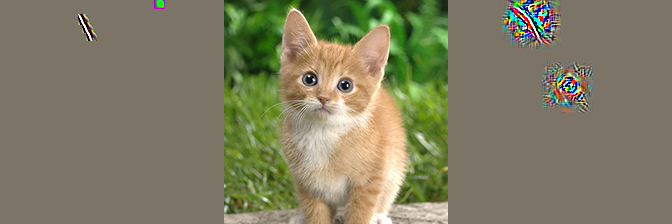

In [14]:
# generate ZF visualisations for layers 1 and 2 of AlexNet
l1,idx_1 = layer1.forward(x_im)
vis1 = layer1.undo(keep_top_k(l1),idx_1,1)

l2,idx_2 = layer2.forward(l1)
vis2 = layer1.undo(layer2.undo(keep_top_k(l2),idx_2),idx_1,1)

# display visualisations
img = data_to_image(vis1[0], x_im[0], vis2[0], 
                    means=(.485, .456, .406), stds=(.229, .224, .225))
display(img, metadata={'width': '100%'})

### Task 5: Convolutional Auto-Encoder 

In contrast to what Zeiler and Fergus did for visualisation,
the transposed convolutions in the decoder of a convolutional auto-encoder
can be learned independently of the convolution in the encoder.
Unpooling operations in the decoder, on the other hand, 
are still tied to the pooling in the encoder.

 > Build a convolutional auto-encoder with two convolutional layers
 > and at least one average pooling layer for the encoder.
 > Make sure that the decoder is symmetric to the encoder.

In [17]:
class ConvAutoEncoder(nn.Module):
    """ Convolutional auto-encoder. """
    
    def __init__(self, in_channels: int, hid_channels: int, code_channels: int, 
                 kernel_size: int, stride: int = 1, pooling: int = 2, 
                 activation: nn.Module = nn.ReLU()):
        """
        Parameters
        ----------
        in_channels : int
            Number of channels in the inputs.
        hid_channels : int
            Number of channels in the hidden layer(s).
        code_channels : int
            Number of channels in the code.
        kernel_size : int or tuple
            Window size for the convolutions
        stride : int or tuple, optional
            Window strides for the convolutions.
        pooling : int or tuple, optional
            Window size for the average pooling.
        activation : nn.Module, optional
            Activation function for the auto-encoder.
        """
        super().__init__()
        
        self.conv_enc_1 = torch.nn.Conv2d(in_channels, hid_channels, kernel_size, stride)
        self.conv_enc_2 = torch.nn.Conv2d(hid_channels, code_channels, kernel_size, stride)
        
        self.activation = activation
        self.avg_pooling = torch.nn.AvgPool2d(kernel_size = pooling)
        
        self.conv_dec_1 = torch.nn.ConvTranspose2d(code_channels, hid_channels, kernel_size, stride)
        self.conv_dec_2 = torch.nn.ConvTranspose2d(hid_channels, in_channels, kernel_size, stride)
        


        

    def forward(self, x):
        enc_1 = self.conv_enc_1(x)
        enc_1 = self.activation(enc_1)
        enc_2 = self.conv_enc_2(enc_1)
        enc_2 = self.activation(enc_2)
        
        avg_pool = self.avg_pooling(enc_2)
        up_avg = torch.nn.functional.interpolate(input = avg_pool,size =(enc_2.shape[2:]))
        
        dec_1 = self.conv_dec_1(up_avg)
        dec_1 = self.activation(dec_1)
        dec_2 = self.conv_dec_2(dec_1)#deleted activation after
        return dec_2
    

        
        
    
    @torch.no_grad()
    def reconstruct(self, x: torch.Tensor) -> torch.Tensor:
        """
        Properly reconstruct some inputs.
        
        Parameters
        ----------
        x : torch.Tensor
            Inputs to be reconstructed.

        Returns
        -------
        y : torch.Tensor
            Result of reconstruction, with values
            in the same range as the targets.
        """
        logits = self.forward(x)
        return torch.clamp(logits, x.min(), x.max())

In [19]:
# sanity check
cae = ConvAutoEncoder(1, 8, 16, 5, pooling=2)
x = torch.randn(1, 1, 28, 28)
y = cae(x)
assert x.shape == y.shape, f"wrong output shape: {y.shape}"
sum(par.numel() for par in cae.parameters())

6833

### Task 6: Convolutional Auto-Encoding 

For (purely) convolutional auto-encoders it is often not clear what the code size is.
How does it compare to a fully connected auto-encoder?
What architecture would you choose if your goal is to learn compression?

 > Train the convolutional auto-encoder on MNIST images
 > in the same way as the simple auto-encoder in Task 2.
 > Print the code size of the convolutional auto-encoder
 > and minimise this code size, while maintaining good reconstructions.


In [20]:
# train convolutional auto-encoder and print code size (see exercise 1)
cae = ConvAutoEncoder(1, 8, 16, 3, pooling=2)
mnist = get_auto_mnist_loader()
loss_func = nn.MSELoss()
train_auto_encoder(cae,mnist,objective = loss_func,optimiser = optim.Adam(cae.parameters(),lr = 0.01),num_epochs = 4,vis_every = 2)




Epoch  0 - avg loss: 1.313411


Epoch  1 - avg loss: 0.008300
Epoch  2 - avg loss: 0.010382


Epoch  3 - avg loss: 0.010028
Epoch  4 - avg loss: 0.010337
